# SlaveVoyages API Example Visualization Usage

This is the first example use case that we built for the new API. Nishant Satpathy, a CS Master's student at Rice, was hired on as an intern with the CRC in 2022. He took my preliminary notebook example and built it out into what follows.

The use case demonstrates how one uses the "[dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)" endpoint (a flat dump of values for one-to-one relations) in order to visualize the numeric data in SV.

I have since [updated the API to have a Pandas microservice](https://github.com/rice-crc/voyages-api/tree/develop/stats) that handles all of this behind the scenes, so the dataframes endpoint should not be used for graphs anymore.

However, this is still a highly useful example for people who would like to use the datframes endpoint to pull the legacy data on all individual voyages (itineraries, dates, and numbers of people transported). I specifically have in mind here the potential for rebuilding the imputation scripts in a notebook format like this.

## Step 1: import packages and auth token

We will be using Pandas to handle the columnar data that is coming back at us, Plotly to visualize it, and some jupyter widgets to show off what we can do in terms of interactively manipulating the dataframes.

In [1]:
import requests
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
import plotly.express as px
import numpy as np
import json
import re
from app_secrets import headers
import requests
# base_url='https://voyages-api-staging.crc.rice.edu/voyage/'
base_url='http://127.0.0.1:8000/voyage/'
headers['Content-Type']= 'application/json'

## Step 2: specify the variables/columns we will be requesting

These arrays provide the variety of variables which can be used for the construction of the data visualizations.

* ```numeric_vars``` are the numerical values we'll be summing, averaging, etc.
* ```geo_vars``` refer to the categorical values that we'll be selecting/grouping by
* ```date_vars``` refer to the ordinal values we'll be selecting/grouping as well as sorting by

The full list of variables can be obtained via an OPTIONS call to the base endpoint for an object -- in this case, ```.../voyages/```.

In [2]:
numeric_vars = ['voyage_slaves_numbers__imp_total_num_slaves_disembarked',
                'voyage_slaves_numbers__imp_total_num_slaves_embarked']

geo_vars = ['voyage_itinerary__imp_principal_place_of_slave_purchase__name',
           'voyage_itinerary__imp_principal_port_slave_dis__name',
           'voyage_itinerary__imp_principal_region_slave_dis__name',
           'voyage_itinerary__imp_principal_region_of_slave_purchase__name']

date_vars = ['voyage_dates__arrival_at_second_place_landing_sparsedate__year',
            'voyage_dates__date_departed_africa_sparsedate__year',
            'voyage_dates__first_dis_of_slaves_sparsedate__year',
            'voyage_dates__imp_arrival_at_port_of_dis_sparsedate__year',
            'voyage_dates__imp_departed_africa_sparsedate__year',
            'voyage_dates__imp_voyage_began_sparsedate__year',
            'voyage_dates__slave_purchase_began_sparsedate__year',
            'voyage_dates__third_dis_of_slaves_sparsedate__year',
            'voyage_dates__vessel_left_port_sparsedate__year',
            'voyage_dates__voyage_began_sparsedate__year',
            'voyage_dates__voyage_completed_sparsedate__year']

r = requests.options(base_url + '?hierarchical=False', headers=headers) # to get the specific label names of above vars
drop_dict = r.json()

## Step 3: Let's use our vars as interactive selectors

The following three widgets are dropdown menues for the above vars. the below array constructions get the specific
labels of the data vars we are trying to use.

In [3]:
geo_drop = [i for i in geo_vars]

geo_emb = widgets.Dropdown(
    options=geo_drop,
    description="Geo Vars",
    layout={'width': 'max-content'},
    disabled=False,
)

In [4]:
numeric_drop = [i for i in numeric_vars]

numeric_emb = widgets.Dropdown(
    options=numeric_drop,
    description="Numeric Vars",
    layout={'width': 'max-content'},
    disabled=False,
)

### Dates are a special case

Because of their ordinal status, selectors should be presented as a range, which we can turn into a rangeslider using the special ```aggregations/``` endpoint in the API.

But in order to do make that slider and use it as a selector, we'll have to first select one single date variable to use in that way.

In [5]:
date_drop = [i for i in date_vars]

dates_emb = widgets.Dropdown(
    options=date_drop,
    description="Dates variable to select on:",
    style={'description_width': 'initial'},
    layout={'width': 'max-content'},
    disabled=False,
)
dates_emb

Dropdown(description='Dates variable to select on:', layout=Layout(width='max-content'), options=('voyage_date…

In [6]:
url = base_url + 'aggregations/'

In [7]:
data = {
    "aggregate_fields" : ['voyage_dates__arrival_at_second_place_landing_sparsedate__year',
            'voyage_dates__date_departed_africa_sparsedate__year',
            'voyage_dates__first_dis_of_slaves_sparsedate__year',
            'voyage_dates__imp_arrival_at_port_of_dis_sparsedate__year',
            'voyage_dates__imp_departed_africa_sparsedate__year',
            'voyage_dates__imp_voyage_began_sparsedate__year',
            'voyage_dates__slave_purchase_began_sparsedate__year',
            'voyage_dates__third_dis_of_slaves_sparsedate__year',
            'voyage_dates__vessel_left_port_sparsedate__year',
            'voyage_dates__voyage_began_sparsedate__year',
            'voyage_dates__voyage_completed_sparsedate__year']
}

In [8]:
r = requests.post(url , data = json.dumps(data), headers = headers)
date_dict = r.json()
# print(json.dumps(date_dict,indent=2))

In [9]:
date_dict = date_dict[date_vars[date_drop.index(dates_emb.value)]]

In [10]:

minyear=int(date_dict['min'])
maxyear=int(date_dict['max'])  # gets the max and the min year for the above chosen date_var and constructs a slider

yearslider_emb = widgets.IntRangeSlider(
    min=minyear,
    max=maxyear,
    step=1,
    description='Date Slider',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

### Ta-da: visual selectors

Let's view and use our visual selector widgets.

All the subsequent calls to the dataframes endpoint and manipulation of the dataframe will be conditioned by these selections.

In [11]:
display(numeric_emb)  # displays the dropdown menus 
display(geo_emb)
display(dates_emb)
display(yearslider_emb)

Dropdown(description='Numeric Vars', layout=Layout(width='max-content'), options=('voyage_slaves_numbers__imp_…

Dropdown(description='Geo Vars', layout=Layout(width='max-content'), options=('voyage_itinerary__imp_principal…

Dropdown(description='Dates variable to select on:', layout=Layout(width='max-content'), options=('voyage_date…

IntRangeSlider(value=(1603, 1768), continuous_update=False, description='Date Slider', max=1851, min=1521)

## Construct our dataframes request

We're going to be making a map, so we'll need to select the lat/long variables associated with each placename variable. Refer again to the options vars if you'd like, but the basic rule here is that we're subbing out the ```__name``` suffix with ```__latitude``` and ```__longitude```.

In [12]:
latvar=re.sub("__[^_]*?$","__latitude",geo_vars[geo_drop.index(geo_emb.value)]) # regex for getting the latitude and longitude
print(latvar)

voyage_itinerary__imp_principal_place_of_slave_purchase__latitude


In [13]:
longvar=re.sub("__[^_]*?$","__longitude",geo_vars[geo_drop.index(geo_emb.value)])
print(longvar)

voyage_itinerary__imp_principal_place_of_slave_purchase__longitude


In [14]:
url = base_url + 'dataframes/'
print(url)

http://127.0.0.1:8000/voyage/dataframes/


### DF request

The DF endpoint requires you to enumerate the columns you'd like returned in the ```selected_fields``` key.

It also allows you to filter on any variable by using that fully-qualified variable name as a key and, in the case of numerical variables, a min/max tuple as your value to filter on.

In [15]:
data = {
    date_vars[date_drop.index(dates_emb.value)] : [yearslider_emb.value[0],yearslider_emb.value[1]],
    "selected_fields" : [
        date_vars[date_drop.index(dates_emb.value)],
        latvar,longvar,
        geo_vars[geo_drop.index(geo_emb.value)],
        numeric_vars[numeric_drop.index(numeric_emb.value)]
    ]
}
print(json.dumps(data,indent=2))


{
  "voyage_dates__arrival_at_second_place_landing_sparsedate__year": [
    1603,
    1768
  ],
  "selected_fields": [
    "voyage_dates__arrival_at_second_place_landing_sparsedate__year",
    "voyage_itinerary__imp_principal_place_of_slave_purchase__latitude",
    "voyage_itinerary__imp_principal_place_of_slave_purchase__longitude",
    "voyage_itinerary__imp_principal_place_of_slave_purchase__name",
    "voyage_slaves_numbers__imp_total_num_slaves_disembarked"
  ]
}


In [16]:
r = requests.post(url , data = json.dumps(data), headers = headers)

## DF Manipulation

Now we load that columnar data, transform it, and visualize it.

### Load it

In [17]:
j = r.text
df = pd.read_json(j)
df

,voyage_dates__arrival_at_second_place_landing_sparsedate__year,voyage_itinerary__imp_principal_place_of_slave_purchase__latitude,voyage_itinerary__imp_principal_place_of_slave_purchase__longitude,voyage_itinerary__imp_principal_place_of_slave_purchase__name,voyage_slaves_numbers__imp_total_num_slaves_disembarked
0,1664,4.950000,8.316670,Calabar,159
1,1664,6.400000,2.200000,Ardra,282
2,1686,6.366670,2.083330,"Bight of Benin, place unspecified",307
3,1709,5.190770,-1.099200,"Gold Coast, port unspecified",284
4,1711,5.182510,-1.116620,Cape Coast Castle,161
...,...,...,...,...,...
386,1619,0.000123,0.000123,Prize (taken from Portuguese),29
387,1725,32.780960,-79.935540,Charleston,40
388,1768,13.100000,-59.600000,"Barbados, place unspecified",257
389,1664,12.100000,-68.916670,Curaçao,502


### Clean & Transform For a Diachronic Map Visualization

* purge the NA values
* sort by the selected date variable
* group by place (using unique lat/longs as proxies for this)
* rename our columns for cleanliness

In [18]:
df = df.dropna()
df = df.sort_values(by=[date_vars[date_drop.index(dates_emb.value)]])

df2 = df.groupby([latvar, # combines data for duplicate geo and date vars. 
                  longvar,
                  geo_vars[geo_drop.index(geo_emb.value)], 
                  date_vars[date_drop.index(dates_emb.value)]], as_index=False).sum()

df2 = df2.rename({latvar: 'Latitude',  # rename the var names to the label names to be more descriptive
                  longvar: 'Longitude', 
                  geo_vars[geo_drop.index(geo_emb.value)]: geo_emb.value,
                  numeric_vars[numeric_drop.index(numeric_emb.value)] : numeric_emb.value,
                  date_vars[date_drop.index(dates_emb.value)]: dates_emb.value, 
                 }, axis=1)

df2 = df2.assign(normalized_sizes = np.log(df2[numeric_emb.value])) # normalize sizes to accommodate various data points

df2 = df2.sort_values(by=dates_emb.value) 
df2

,Latitude,Longitude,voyage_itinerary__imp_principal_place_of_slave_purchase__name,voyage_dates__arrival_at_second_place_landing_sparsedate__year,voyage_slaves_numbers__imp_total_num_slaves_disembarked,normalized_sizes
3,-8.83833,13.23444,Luanda,1605,581,6.364751
25,-8.83833,13.23444,"West Central Africa and St. Helena, port unspe...",1605,314,5.749393
4,-8.83833,13.23444,Luanda,1608,533,6.278521
113,0.33333,6.73333,São Tomé,1608,331,5.802118
5,-8.83833,13.23444,Luanda,1609,331,5.802118
...,...,...,...,...,...,...
44,-8.83833,13.23444,"West Central Africa and St. Helena, port unspe...",1768,179,5.187386
243,13.10000,-59.60000,"Barbados, place unspecified",1768,257,5.549076
55,-5.55000,12.20000,Cabinda,1768,374,5.924256
60,-5.33333,12.18333,Malembo,1768,301,5.707110


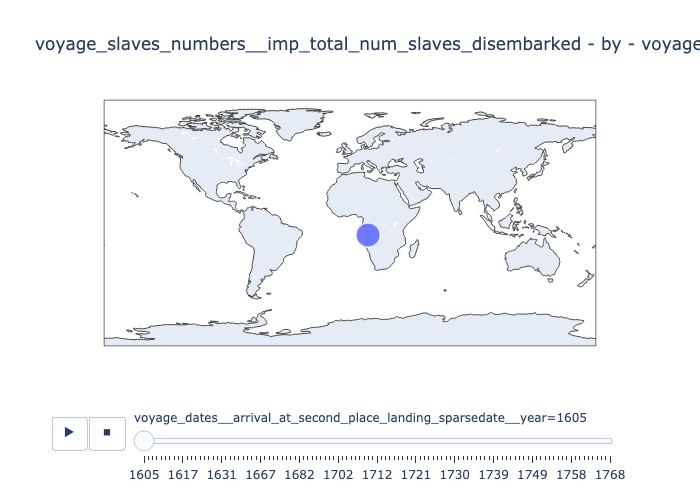

In [19]:
fig = px.scatter_geo(df2, lon = 'Longitude', # constructs the bubble map 
                     lat = 'Latitude',
                     title = '%s - by - %s' %(numeric_emb.value,geo_emb.value),
                     hover_name = geo_emb.value,
                     animation_frame = dates_emb.value,
                     size = 'normalized_sizes',
                     hover_data = [numeric_emb.value])
#for github:
fig.show("png")
#otherwise use
#fig.show()

### The same data works for a grouped bar graph

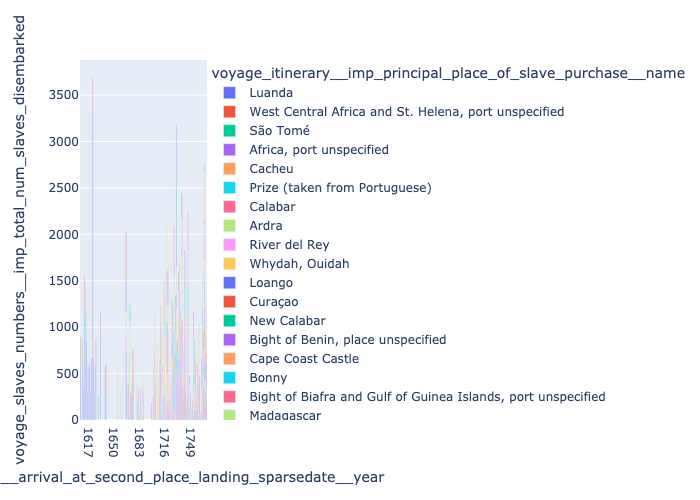

In [21]:

fig = px.bar(df2, x=dates_emb.value, # constructs the stacked bar graph
             y=numeric_emb.value, color=geo_emb.value
             )
fig.update_xaxes(dtick=int((maxyear-minyear)/10)) # updates the interval between each tick on the x-axis.
#for github
fig.show("png")
#otherwise use
#fig.show()